# DNN 网络识别手写图片
本节仍属于 [PyTorch深度学习：深度神经网络（DNN）](https://www.bilibili.com/video/BV1Z8411R7PH) 的范畴，与之前的激活函数略有不同，故另起一页。


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline

# 数据集相关
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

接下来就要对图像进行张量化和归一化处理，具体的解释可以参考 [https://juejin.cn/post/7087397616731815966](https://juejin.cn/post/7087397616731815966)

下面对两个过程进行简单的解释：

## ToTensor 张量化

这个函数会吧 PIL Image 对象转化为 Numpy 数组，具体来说他干了两个事情：

- 将 (H x W x C) 格式的图片转化为 (C x H x W) ， HWC 格式的图片是以 高、宽、颜色 进行存储的，即读取的时候需要通过 image\[h, w, c\] 来获取图片像素值，而 CHW 格式存取时使用的是类似 image\[c, h, w\] 来获取图片像素值，前者是先定位高宽再取像素维度，后者是先取维度再取高宽。这样做的好处是，在读取的时候像素永远是同一个通道排在一起的，有助于神经网络理解同维度像素左右的联系。
- 将像素值 \[0, 255\] 的区间映射为 \[0.0, 1.0\] 的区间，将大数据变小，对神经网络更加友好。

## Normalize 归一化

将 \[\~0.0, \~1.0\] 之间的数据变为 \[\~-1.0, \~1.0\] 之间，使其整个训练集的输入均值为 0 ，方差为 1，让神经网络中的 bias 可以在负数与正数内取值，接近原点，使梯度下降更高效，加快收敛速度。

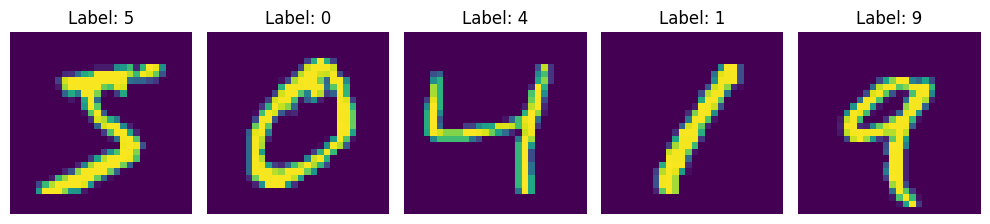

In [2]:
# 转化为张量与归一化处理
# transform = transforms.Compose(  # 将多个图像变换操作组合在一起
#     [
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#     ]
# )

# 下载训练集
train_Data_raw = datasets.MNIST(
    root='./datasets/mnist/',
    train=True,
    download=True,
    transform=None
)
test_Data_raw = datasets.MNIST(
    root='./datasets/mnist/',
    train=False,
    download=True,
    transform=None
)

# 展示 5 张照片
plt.figure(figsize=(10, 4))
for _ in range(5):
    img, label = train_Data_raw[_]
    plt.subplot(1, 5, _ + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [3]:
# 手动进行张量化和归一化
class DatasetMNIST(Dataset):
    def __init__(self, raw):
        super().__init__()
        self.raw = raw
        self.imgs = []
        self.labels = []

        self.ToTensor = transforms.ToTensor()
        self.Normalize = transforms.Normalize((0.1307,), (0.3081,))

        # 其实可以一把写完，但是这里为了展示中间过程所以拆开
        for img, label in self.raw:
            self.imgs.append(self.ToTensor(img))
            self.labels.append(label)

        print(self.imgs[0])

        for i in range(len(self.imgs)):
            self.imgs[i] = self.Normalize(self.imgs[i])

        print(self.imgs[0])

    def __getitem__(self, index):
        return self.imgs[index], self.labels[index]

    def __len__(self):
        return len(self.imgs)


train_Data = DatasetMNIST(train_Data_raw)
test_Data = DatasetMNIST(test_Data_raw)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [4]:
# 构建神经网络
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),  # 把输入摊平
            nn.Linear(28 * 28, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
# 批处理数据集
train_loader = DataLoader(train_Data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_Data, batch_size=64, shuffle=True)

In [6]:
# 初始化训练参数
net = net().to('cuda')

epoch = 10
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()  # 损失器
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # 优化器

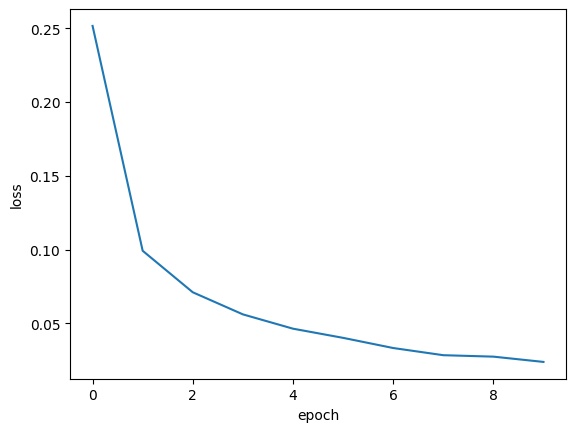

In [7]:
# 开始训练
total_losses = []

for epoch_ in range(epoch):
    batch_losses = []
    for x, y in train_loader:
        x = x.to('cuda')
        y = y.to('cuda')
        pred = net(x)
        loss = loss_fn(pred, y)
        batch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_losses.append(sum(batch_losses) / len(batch_losses))

Fig = plt.figure()
plt.plot(range(epoch), total_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [8]:
# 测试模型
total = 0
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x = x.to('cuda')
        y = y.to('cuda')
        pred = net(x)
        correct += torch.sum(torch.argmax(pred, dim=1) == y)
        total += y.size(0)

print(f"正确率：{correct / total * 100:.2f}%")

正确率：97.88%


In [9]:
from tools.ipynb_draw import DrawCanvas
from IPython.display import display
from ipywidgets import Button
from PIL import Image

dc = DrawCanvas(width=58, height=58)

callback_button = Button(description="识别")

def callback(_):
    with dc.out:
        try:
            np_img = dc.canvas.get_image_data(width=58, height=58)
            img = Image.fromarray(np_img)
            transform = transforms.Compose([
                transforms.Grayscale(),  # 如果是彩色图像转为灰度
                transforms.Resize((28, 28)),  # 调整大小为28x28
                transforms.ToTensor(),  # 转为张量并归一化到[0,1]
                transforms.Normalize((0.1307,), (0.3081,))  # 标准化到[-1,1]
            ])

            # 对图像进行预处理
            input_tensor = transform(img).unsqueeze(0).to('cuda')  # 添加batch维度 (1, 1, 28, 28)

            # 3. 前向传播
            with torch.no_grad():  # 不需要计算梯度
                output = net(input_tensor)
                prediction = torch.argmax(output, dim=1).item()  # 获取预测类别
                print(prediction)
        except BaseException as e:
            print(str(e))

callback_button.on_click(callback)


layout = dc.get_layout()
layout.children[1].children = layout.children[1].children + (callback_button,)
display(layout)

实际上对于纯神经网络输入的识别效果并不好，必须是很接近训练集的数据才能准确的识别，对不同类型的图片的泛化能力其实不太行。

# 损失函数说明

CrossEntropyLoss（交叉熵损失）、MSELoss（均方误差损失）和BCELoss（二元交叉熵损失）是深度学习中常用的损失函数，它们在应用场景、数学形式和适用任务上有显著差异。以下是它们的异同点分析：

---

### **1. 核心区别**
| **损失函数**       | **主要应用场景**               | **输出类型**       | **数学形式**                          | **特点**                                                                 |
|--------------------|-------------------------------|--------------------|---------------------------------------|--------------------------------------------------------------------------|
| **CrossEntropyLoss** | 多分类任务（单标签）           | 概率分布（Softmax）| \(-\sum_{c=1}^C y_c \log(p_c)\)       | 结合Softmax，直接优化多类概率分布，对错误分类敏感。                       |
| **BCELoss**         | 二分类任务或多标签分类         | 独立概率（Sigmoid）| \(-\frac{1}{N}\sum_{i=1}^N [y_i \log(p_i) + (1-y_i)\log(1-p_i)]\) | 每个输出节点独立计算二元概率，需显式Sigmoid激活。                         |
| **MSELoss**         | 回归任务（连续值预测）         | 任意实数           | \(\frac{1}{N}\sum_{i=1}^N (y_i - p_i)^2\) | 对异常值敏感，假设误差服从高斯分布，分类任务中可能导致梯度消失。           |

---

### **2. 相同点**
- **目标**：均用于衡量模型预测值与真实值的差异，指导模型参数优化。
- **可微性**：均为可微函数，支持梯度下降法优化。

---

### **3. 关键差异**
#### **(1) 任务类型**
- **CrossEntropyLoss**：专为**单标签多分类**设计（如MNIST手写数字识别）。
- **BCELoss**：适用于**二分类**或**多标签分类**（如同时预测多个疾病的概率）。
- **MSELoss**：主要用于**回归问题**（如房价预测），分类任务中效果较差。

#### **(2) 概率建模**
- **CrossEntropyLoss**：隐含Softmax，强制输出为概率分布（\(\sum p_c = 1\)）。
- **BCELoss**：对每个输出节点单独应用Sigmoid，概率独立（适合非互斥类别）。
- **MSELoss**：无概率约束，直接拟合数值。

#### **(3) 梯度特性**
- **CrossEntropyLoss**：梯度与误差成比例（\(p_c - y_c\)），错误分类时梯度大，收敛快。
- **BCELoss**：类似但对每个节点独立计算。
- **MSELoss**：梯度与误差线性相关（\(2(y_i - p_i)\)），在分类任务中可能导致梯度饱和（如Sigmoid输出接近0/1时）。

#### **(4) 异常值鲁棒性**
- MSELoss对异常值敏感（平方放大误差），而交叉熵损失对概率偏差更敏感。

---

### **4. 选择建议**
- **多分类任务**：优先使用`CrossEntropyLoss`（PyTorch中结合Softmax，无需手动激活）。
- **二分类/多标签分类**：使用`BCELoss` + `Sigmoid`。
- **回归任务**：使用`MSELoss`或`HuberLoss`（对异常值鲁棒）。
- **避免**：用MSELoss处理分类问题（概率拟合不合理，梯度不稳定）。
